In [4]:
import numpy as np

np.random.seed(42)   # критично для відтворюваності

m = 10000   # кількість рядків (m >> n)
n = 100     # кількість ознак

A = np.random.randn(m, n)

x_true = np.random.randn(n)
noise = 0.01 * np.random.randn(m)

b = A @ x_true + noise


In [6]:

def deterministic_ls(A, b):
    Q, R = np.linalg.qr(A, mode="reduced")
    x = np.linalg.solve(R, Q.T @ b)
    return x


In [7]:
x_star = deterministic_ls(A, b)



In [2]:
def gaussian_sketch_and_solve(A, b, s):
    m, n = A.shape
    S = np.random.randn(s, m) / np.sqrt(s)

    A_s = S @ A
    b_s = S @ b

    Q, R = np.linalg.qr(A_s, mode="reduced")
    x_tilde = np.linalg.solve(R, Q.T @ b_s)
    return x_tilde


In [8]:
s = 400   # sketch size (s > n)

x_gauss = gaussian_sketch_and_solve(A, b, s)


In [ ]:
from scipy.linalg import hadamard
import math

def fjlt_sketch(A, b, s):
    m, n = A.shape
    # Знайти найменший степінь 2, >= m
    m_pow2 = 2 ** math.ceil(math.log2(m))
    
    # Розширити матриці нулями до розміру степеня 2
    A_padded = np.vstack([A, np.zeros((m_pow2 - m, n))])
    b_padded = np.concatenate([b, np.zeros(m_pow2 - m)])
    
    D = np.diag(np.random.choice([-1, 1], size=m_pow2))
    H = hadamard(m_pow2) / np.sqrt(m_pow2)

    idx = np.random.choice(m_pow2, size=s, replace=False)
    P = np.eye(m_pow2)[idx]

    S = P @ H @ D

    A_s = S @ A_padded
    b_s = S @ b_padded

    Q, R = np.linalg.qr(A_s, mode="reduced")
    x_tilde = np.linalg.solve(R, Q.T @ b_s)
    return x_tilde


In [12]:
def uniform_sampling_sketch_and_solve(A, b, s):
    m = A.shape[0]
    idx = np.random.choice(m, size=s, replace=False)

    A_tilde = A[idx, :]
    b_tilde = b[idx]

    Q, R = np.linalg.qr(A_tilde, mode="reduced")
    x_tilde = np.linalg.solve(R, Q.T @ b_tilde)
    return x_tilde


In [9]:
rel_error = np.linalg.norm(A @ x_gauss - b) / np.linalg.norm(A @ x_star - b)
print("Approximation factor:", rel_error)


Approximation factor: 1.1477855267956905


In [18]:
import time
import matplotlib.pyplot as plt

# Функція для вимірювання часу виконання
def measure_time(func, A, b, s, n_runs=3):
    """Виміряє середній час виконання функції"""
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        result = func(A, b, s)
        end = time.perf_counter()
        times.append((end - start) * 1000)  # переводимо в мілісекунди
    return np.mean(times), result

# Порівняння часу для різних sketch size
sketch_sizes = [100, 150, 200, 400, 600, 800]  # мінімум s >= n=100
times_gaussian = []
times_uniform = []
times_fjlt = []

for size in sketch_sizes:
    t_gauss, _ = measure_time(gaussian_sketch_and_solve, A, b, size)
    times_gaussian.append(t_gauss)
    
    t_uniform, _ = measure_time(uniform_sampling_sketch_and_solve, A, b, size)
    times_uniform.append(t_uniform)
    
    t_fjlt, _ = measure_time(fjlt_sketch, A, b, size)
    times_fjlt.append(t_fjlt)
    
    print(f"Sketch size {size}: Gaussian={t_gauss:.4f}ms, Uniform={t_uniform:.4f}ms, FJLT={t_fjlt:.4f}ms")


ValueError: n must be an positive integer, and n must be a power of 2

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

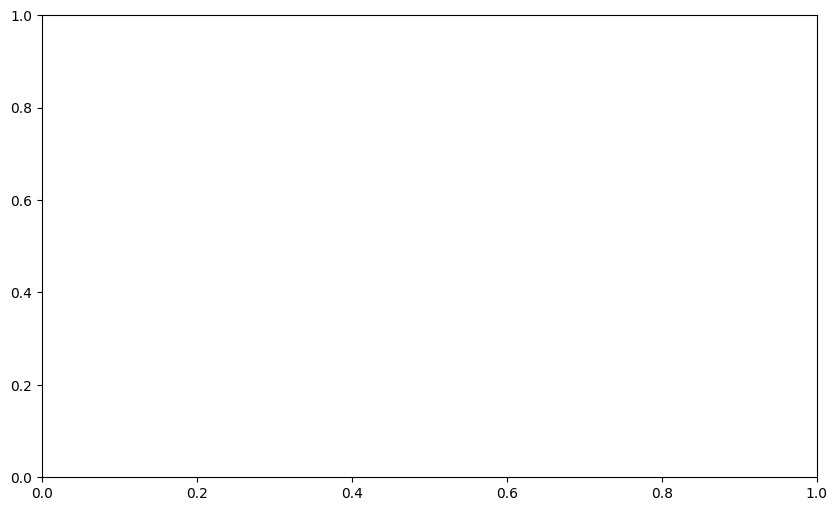

In [17]:
# Графіки: час виконання vs sketch size
plt.figure(figsize=(10, 6))
plt.plot(sketch_sizes, times_gaussian, 'o-', label='Gaussian Sketching', linewidth=2, markersize=8)
plt.plot(sketch_sizes, times_uniform, 's-', label='Uniform Sampling', linewidth=2, markersize=8)
plt.plot(sketch_sizes, times_fjlt, '^-', label='FJLT Sketching', linewidth=2, markersize=8)

plt.xlabel('Sketch Size (s)', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title(f'Execution Time vs Sketch Size (m={m}, n={n})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Порівняння часу залежно від розміру матриці (m)
matrix_sizes = [1000, 2000, 5000, 10000, 15000]
times_by_m = {'Gaussian': [], 'Uniform': [], 'FJLT': []}

sketch_ratio = 0.04  # sketch size буде 4% від m

for m_val in matrix_sizes:
    A_temp = np.random.randn(m_val, n)
    x_true_temp = np.random.randn(n)
    b_temp = A_temp @ x_true_temp + 0.01 * np.random.randn(m_val)
    
    s_val = int(m_val * sketch_ratio)
    
    t_gauss, _ = measure_time(gaussian_sketch_and_solve, A_temp, b_temp, s_val)
    times_by_m['Gaussian'].append(t_gauss)
    
    t_uniform, _ = measure_time(uniform_sampling_sketch_and_solve, A_temp, b_temp, s_val)
    times_by_m['Uniform'].append(t_uniform)
    
    t_fjlt, _ = measure_time(fjlt_sketch, A_temp, b_temp, s_val)
    times_by_m['FJLT'].append(t_fjlt)
    
    print(f"m={m_val}, s={s_val}: Gaussian={t_gauss:.4f}ms, Uniform={t_uniform:.4f}ms, FJLT={t_fjlt:.4f}ms")


In [ ]:
# Графіки: час виконання vs розмір матриці
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Лінійна шкала
axes[0].plot(matrix_sizes, times_by_m['Gaussian'], 'o-', label='Gaussian Sketching', linewidth=2, markersize=8)
axes[0].plot(matrix_sizes, times_by_m['Uniform'], 's-', label='Uniform Sampling', linewidth=2, markersize=8)
axes[0].plot(matrix_sizes, times_by_m['FJLT'], '^-', label='FJLT Sketching', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Rows (m)', fontsize=12)
axes[0].set_ylabel('Time (ms)', fontsize=12)
axes[0].set_title('Execution Time vs Matrix Size', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Логарифмічна шкала
axes[1].loglog(matrix_sizes, times_by_m['Gaussian'], 'o-', label='Gaussian Sketching', linewidth=2, markersize=8)
axes[1].loglog(matrix_sizes, times_by_m['Uniform'], 's-', label='Uniform Sampling', linewidth=2, markersize=8)
axes[1].loglog(matrix_sizes, times_by_m['FJLT'], '^-', label='FJLT Sketching', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Rows (m)', fontsize=12)
axes[1].set_ylabel('Time (ms)', fontsize=12)
axes[1].set_title('Execution Time vs Matrix Size (log scale)', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()
